## AISE4010- Assignment2 - Time Series Forecasting using CNN, RNN, LSTM and GRU

## Grade: 100 points

### Instructions

#### Follow These Steps before submitting your assignment

1. Complete the notebook.

2. Make sure all plots have axis labels.

3. Once the notebook is complete, `Restart` your kernel by clicking 'Kernel' > 'Restart & Run All'.

4. Fix any errors until your notebook runs without any problems.

5. Submit one completed notebook for the group to OWL by the deadline.

6. Make sure to reference all external code and documentation used.

### Dataset

The `StockData.csv` represents a time series dataset designed to simulate the behavior of stock prices over a period of 1000 days, starting from January 1, 2023. This dataset includes key features commonly found in stock market data, such as opening prices, closing prices, daily highs, daily lows, and trading volume.

Features:
- Date: The timestamp representing the specific day for each record.
- Open: The stock's price at the start of the trading day.
- High: The highest price of the stock during the trading day. It is generally higher than the opening price, reflecting intraday market movements.
- Low: The lowest price of the stock during the trading day. It is usually lower than the opening price, capturing downward movements in the market.
- Close: The stock’s price at the end of the trading day. This price reflects the market's closing valuation and fluctuates within a range close to the opening price.
- Volume: The number of shares traded during the day.

### Question 1 - Data Preprocessing (15%)
- Q1.1 Load the provided dataset and plot the `Closing prices` time series. (5%)
- Q1.2 (5%):

  - a) Decompose the time series into its components and explain them.  
  - b) What do the trend and seasonality components tell you about the overall behavior of the time series? How does understanding     these components help in selecting a model for time series forecasting?
- Q1.3 Restructure the time series using a sliding window approach (with size 10) to prepare it for supervised learning. Split the `Closing prices` time series into 80% for training and 20% for testing. (5%)


Missing Values Summary

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Rows available: 1500
Date range: 2023-01-01 to 2027-02-08

                 Close
Date                  
2023-01-01  106.579055
2023-01-02  100.398438
2023-01-03  106.660228
2023-01-04  111.932348
2023-01-05   98.844836


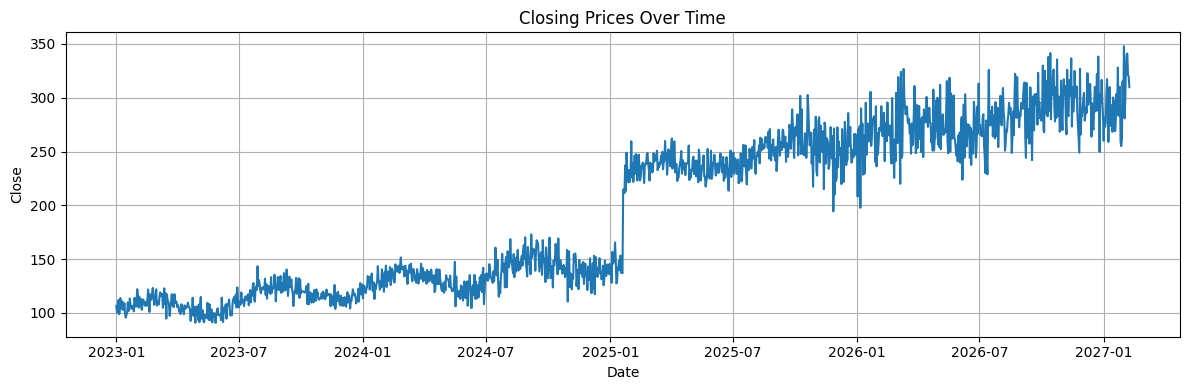

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('StockData.csv')

print("Missing Values Summary\n")
dfNull = df.isnull().sum()
print(dfNull)

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

ts = df.set_index('Date')[['Close']]

print(f"\nRows available: {len(ts)}")
print(f"Date range: {ts.index[0].date()} to {ts.index[-1].date()}\n")
print(ts.head())

plt.figure(figsize=(12, 4))
plt.plot(ts.index, ts['Close'])
plt.title("Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Close")
plt.grid(True)
plt.tight_layout()
plt.show()

Q1.2 — Decomposition (head):
              Observed       Trend  Seasonal  Residual
Date                                                  
2023-01-01  106.579055         NaN  0.965642       NaN
2023-01-02  100.398438         NaN -0.590149       NaN
2023-01-03  106.660228         NaN -0.778699       NaN
2023-01-04  111.932348  105.477690  1.368293  5.086366
2023-01-05   98.844836  105.287887 -1.269483 -5.173568
2023-01-06  100.159872  105.768476 -0.663389 -4.945215
2023-01-07  113.769050  106.342763  0.967784  6.458503
2023-01-08  105.250438  105.046167  0.965642 -0.761371
2023-01-09  103.762558  105.841017 -0.590149 -1.488310
2023-01-10  110.680238  107.097886 -0.778699  4.361050
2023-01-11  102.856175  104.981286  1.368293 -3.493404
2023-01-12  104.408787  103.625766 -1.269483  2.052503
2023-01-13  108.957959  102.873836 -0.663389  6.747512
2023-01-14   98.952847  101.363675  0.967784 -3.378612

Trend direction (slope sign): upward
Seasonal amplitude (peak-to-peak, 7-step cycle): ~2.6

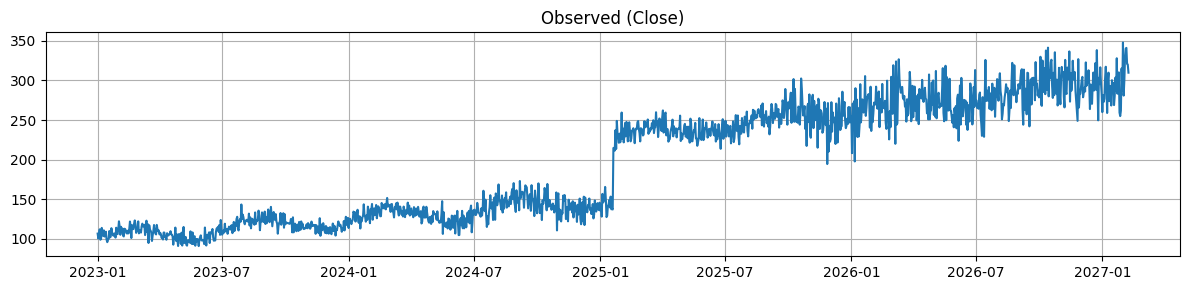

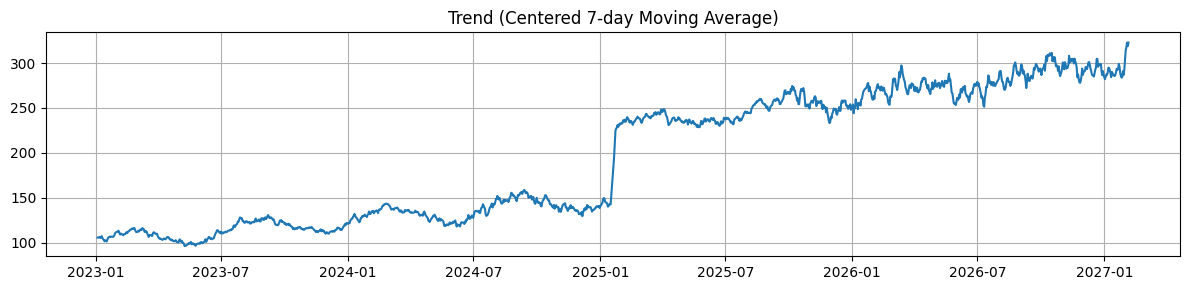

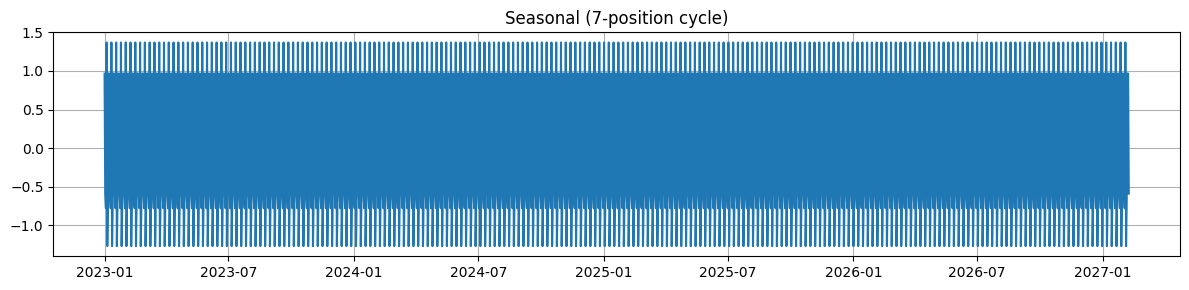

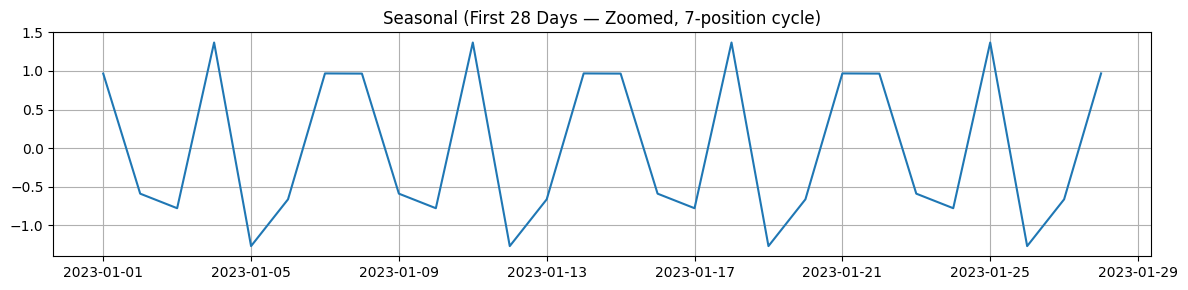

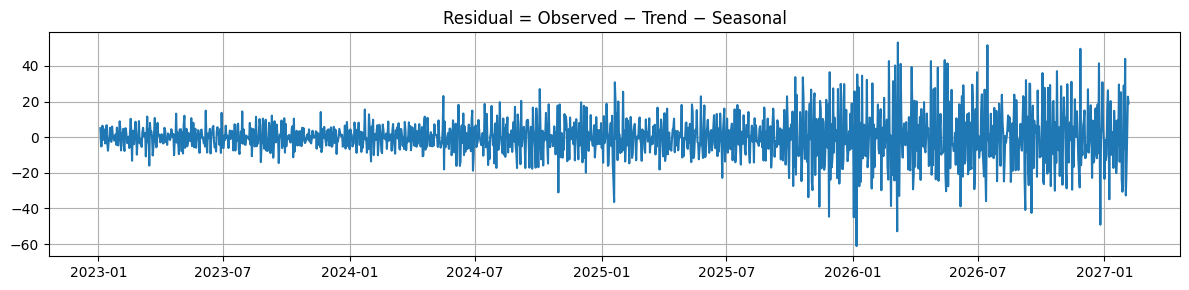

In [3]:
import numpy as np

period = 7  # ~ one trading week

# 1) Trend: centered 7-day moving average

#   Trend = (Close_{t-3} + ... Close_{t+3}) / 7
#         - The first/last 3 rows have no centered window so Nan (expected)

trend = ts['Close'].rolling(window=period, center=True).mean()

# 2) Seasonality: average detrended value at each cycle position (0..6)
#    2.1 - Detrend: how much each point deviates from its local level (value provided around that day from the trend)
#        - Detrend = Close - Trend

detrended = ts['Close'] - trend

#    2.2 = Assign each row a cycle position p(t) = t mod 7

pos = np.arange(len(ts)) % period

#    2.3 - For each position k in {0...6}, average the dtrended values across the whole series
#        - S_index[k] = mean{Detrended | pos(t) = k}

seasonal_index = pd.Series(detrended.values, index=pos).groupby(level=0).mean()

#    2.4 - Enforce additive zero-mean seasonality over one full cycle:
#        - S_index[k] = S_index[k] - [sum_j S_index[j]]/7

seasonal_index -= seasonal_index.mean()

#    2.5 - Map the 5 indices back to every row via its position:
#        - Seasonal = S_index[pos(t)]

seasonal = seasonal_index.reindex(pos).to_numpy()

# 3) Residual

#   Residual = Close - Trend - Seasonal
#            = Residual will be NaN where Trend is NaN

residual = ts['Close'].to_numpy() - trend.to_numpy() - seasonal

# 4) Pack results for inspection / plotting
decomp = pd.DataFrame(
    {'Observed': ts['Close'].to_numpy(),   #Original series Close
     'Trend': trend.to_numpy(),            #Centered 7-day moving average
     'Seasonal': seasonal,                 #Repeating 7-step pattern
     'Residual': residual},
    index=ts.index
)

# Quick preview
print("Q1.2 — Decomposition (head):")
print(decomp.head(14))

# Analyze components for discussion

#1. Fit a line on the valid Trend to see if its rising or falling
trend_valid = decomp['Trend'].dropna()

if len(trend_valid) > 8:

    x = np.arange(len(trend_valid))
    slope = np.polyfit(x, trend_valid.values, 1)[0]
    trend_dir = "upward" if slope > 0 else ("downward" if slope < 0 else "flat")

else:

    trend_dir = "n/a"

#2. Seasonal Amplitude: Peak-to-peak size of the repeating 7-step pattern
seasonal_amp = float(np.nanmax(decomp['Seasonal']) - np.nanmin(decomp['Seasonal']))

#3. Residual std: how noisy the unexplained remainder is
resid_std = float(np.nanstd(decomp['Residual']))

print(f"\nTrend direction (slope sign): {trend_dir}")
print(f"Seasonal amplitude (peak-to-peak, 7-step cycle): ~{seasonal_amp:.3f}")
print(f"Residual std: ~{resid_std:.3f}")

# 5) Plots (simple, consistent)
plt.figure(figsize=(12, 3))
plt.plot(decomp.index, decomp['Observed'])
plt.title("Observed (Close)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(decomp.index, decomp['Trend'])
plt.title("Trend (Centered 7-day Moving Average)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(decomp.index, decomp['Seasonal'])
plt.title("Seasonal (7-position cycle)")
plt.grid(True)
plt.tight_layout()
plt.show()

# NEW: Zoomed seasonal plot (first 28 days ≈ 4 full cycles) for visual clarity
sample_length = 28
plt.figure(figsize=(12, 3))
plt.plot(decomp.index[:sample_length], decomp['Seasonal'][:sample_length])
plt.title(f"Seasonal (First {sample_length} Days — Zoomed, 7-position cycle)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(decomp.index, decomp['Residual'])
plt.title("Residual = Observed − Trend − Seasonal")
plt.grid(True)
plt.tight_layout()
plt.show()


#**Q1.2(a)** - Decomposition Components

**Observed:** This is the raw closing price directly from the dataset - it includes the combined effect of long-term growth, short-term repetitive cycles, and noise.

**Trend:** A smoothed version of the price that captures the long-term direction of movement, ignoring short-term fluctuations. In this dataset the trend shows a gradual upward increase over time, with a significant jump around early 2025, indicating strong long term market growth rather than random fluctuation.

**Seasonal:** A repeating short-term 7-step pattern that cycles consistently over time. This reflects small but predicatble oscillations around the trend, likely due to systematic short-term behavior. The amplitude shows that seasonality influences short-term variation but does not dominate overall direction.

**Residual:** Whatever remains after the trend and seasonality are removed - it represents noise caused by market shocks, news events, or random trading activity.

#**Q1.2(b)** - Interpretation of Trend & Seasonality

**Trend:** The trend shows a strong upward long-term movement, indicating the asset is generally growin in value over timie, with a major increase starting around 2025.

**Seasonality:** The seasonal component exhibits a stable, repeating 7-day cycle, suggesting consistent short-term fluctuations that repeat regularly.

****

**Why This Matters For Forecasting**

Since there is a clear upward trend, we should use a forecasting model that supports non-stationarity. Because seasonality is present and stable, a seasonality-aware model will perfrom better than a model that assumes the data has no repeating pattern. SARIMA or LSTM could be good models to use on this dataset.

In [4]:
from sklearn.preprocessing import MinMaxScaler

# 1) Extract Close series
prices = ts['Close'].values.astype(float)

# 2) Build sliding windows (window = 10)
WINDOW = 10
X, y = [], []
for i in range(len(prices) - WINDOW):
    X.append(prices[i : i + WINDOW])   # Input: Contains 10 consecutive past closing prices (day t to t+9)
    y.append(prices[i + WINDOW])       # Output: The close immediately after those 10 days (day t+10)
X = np.array(X)
y = np.array(y)

print("Q1.3 — Raw supervised arrays")
print(f"X shape (samples, window): {X.shape}")
print(f"y shape (samples,):       {y.shape}")

# 3) 80/20 split INDEX
#    - We are not shuffling the data because the time must remain sequential

split_idx = int(len(X) * 0.8)

# 4) Normalize (GLOBAL scaling: fit on TRAIN ONLY, apply to all)
#    - MinMax to [0,1] (good for NN training stability)
#    - Fit x_scaler on all values from TRAIN windows; fit y_scaler on TRAIN targets

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_scaler.fit(X[:split_idx].reshape(-1, 1))
y_scaler.fit(y[:split_idx].reshape(-1, 1))

# Transform 2D window arrays with a single scaler
def transform_windows(arr2d, scaler):
    flat = arr2d.reshape(-1, 1)
    flat_scaled = scaler.transform(flat)
    return flat_scaled.reshape(arr2d.shape)

X_scaled = transform_windows(X, x_scaler)
y_scaled = y_scaler.transform(y.reshape(-1, 1))

# 5) Final chronological split (no shuffling)
X_train = X_scaled[:split_idx].copy()
X_test  = X_scaled[split_idx:].copy()
y_train = y_scaled[:split_idx].copy()
y_test  = y_scaled[split_idx:].copy()

print("\nQ1.3 — Train/Test split (80/20 chronological)")
print(f"Training set shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Test set shape:     X_test  {X_test.shape},  y_test  {y_test.shape}")

Q1.3 — Raw supervised arrays
X shape (samples, window): (1490, 10)
y shape (samples,):       (1490,)

Q1.3 — Train/Test split (80/20 chronological)
Training set shape: X_train (1192, 10), y_train (1192, 1)
Test set shape:     X_test  (298, 10),  y_test  (298, 1)


### Question2 - 1D Convolutional Neural Network (CNN) (20%)
- Q2.1 Create a 1D CNN model for time series forecasting. The model should have two convolutional layers of size 64 and 32 and kernel size of 3, fully connected layer of size 50, droup out of 0.3, and ReLU activation. Train the model using the provided dataset for 50 epochs. Use the batch_size of 32, and ADAM optimizer. Plot the training loss and validation loss. (12%)
- Q2.2 Evaluate the model's performance using RMSE and MAE on the test set. Plot the predicted values alongside the actual values to visualize how well the model is forecasting the time series. (6%)
- Q2.3 How does the 1D-CNN perform in terms of capturing short-term dependencies? Based on the RMSE and MAE values, do you think this model can effectively capture long-term trends? Why or why not? (2%)


Q2.1 — Shapes ready for CNN
X_train_cnn: (1192, 10, 1)  (samples, timesteps=10, features=1)
X_test_cnn: (298, 10, 1)
y_train: (1192,)
y_test: (298,)

Q2.1 — Train/Val split (from training set)
X_tr:  (1072, 10, 1), y_tr:  (1072,)
X_val: (120, 10, 1), y_val: (120,)



c:\Users\rayta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        16,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,533 (88.02 KB)

 Trainable params: 22,533 (88.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0669 - mae: 0.1719 - val_loss: 0.0092 - val_mae: 0.0742
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - mae: 0.0599 - val_loss: 0.0099 - val_mae: 0.0782
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - mae: 0.0531 - val_loss: 0.0092 - val_mae: 0.0740
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - mae: 0.0529 - val_loss: 0.0103 - val_mae: 0.0796
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - mae: 0.0537 - val_loss: 0.0092 - val_mae: 0.0738
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - mae: 0.0483 - val_loss: 0.0099 - val_mae: 0.0780
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - mae: 0.0496 - val_loss: 0.0102 - val_mae: 0.0792
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - mae: 0.0508 - val_loss: 0.0091 - val_mae: 0.0740
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - mae:

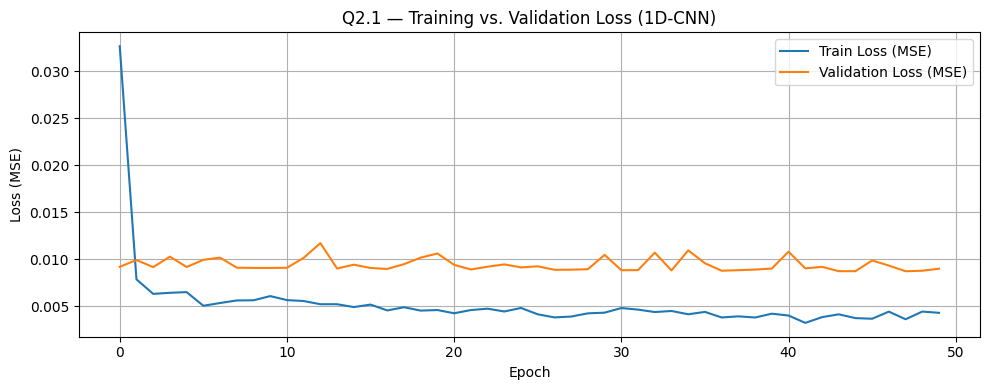

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

#1) Prepare shapes for Conv1D
#   - Conv1D expects input: (samples, timesteps, features) so we must change our input to this format
#         - (1, 10, 1): Each input sample is a 10-day sequence, with 1 value per day (the closing price)
#   - We reshape our output to 1D - Keras prefers 1D targets for regression.

WINDOW = X_train.shape[1]
X_train_cnn = X_train.reshape(-1, WINDOW, 1)
X_test_cnn  = X_test.reshape(-1, WINDOW, 1)

y_train_vec = y_train.ravel()
y_test_vec  = y_test.ravel()

print("Q2.1 — Shapes ready for CNN")
print(f"X_train_cnn: {X_train_cnn.shape}  (samples, timesteps={WINDOW}, features=1)")
print(f"X_test_cnn: {X_test_cnn.shape}")
print(f"y_train: {y_train_vec.shape}")
print(f"y_test: {y_test_vec.shape}")

# 2) Chronological validation split from the training set
#   - Used to monitor learning progress during training. We are using the last 10% of training for validation
#   - Check's if the data is overfitting or underperforming. We keep the data in chronological order.

val_start = int(len(X_train_cnn) * 0.9)
X_tr, X_val = X_train_cnn[:val_start], X_train_cnn[val_start:]
y_tr, y_val = y_train_vec[:val_start],  y_train_vec[val_start:]

print("\nQ2.1 — Train/Val split (from training set)")
print(f"X_tr:  {X_tr.shape}, y_tr:  {y_tr.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}\n")

# 3) Define the 1D CNN per spec:
#    - Conv1D: 64 filters, kernel_size=3, ReLU
#    - Conv1D: 32 filters, kernel_size=3, ReLU
#    - Dense:  50 units, ReLU    -  Learns nonlinear relationships between extracted features
#    - Dropout: 0.3              -  Prevents overfitting by randomly dropping 30% of neurons
#    - Output: 1 (regression)
#    - Optimizer: Adam           -  Automatically adapts the learning rate during training.
#    - Loss: MSE

tf.random.set_seed(42)
np.random.seed(42)

model = models.Sequential([
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(WINDOW, 1)),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

model.compile(optimizer=optimizers.Adam(), loss='mse', metrics=['mae'])
model.summary()

# 4) Train for 50 epochs, batch_size=32
EPOCHS = 50
BATCH_SIZE = 32

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# 5) Plot training vs validation loss (MSE)
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='Train Loss (MSE)')
plt.plot(val_loss,   label='Validation Loss (MSE)')
plt.title("Q2.1 — Training vs. Validation Loss (1D-CNN)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Q2.2 — Test Metrics (original price scale)
RMSE: 21.4039
MAE : 17.3342


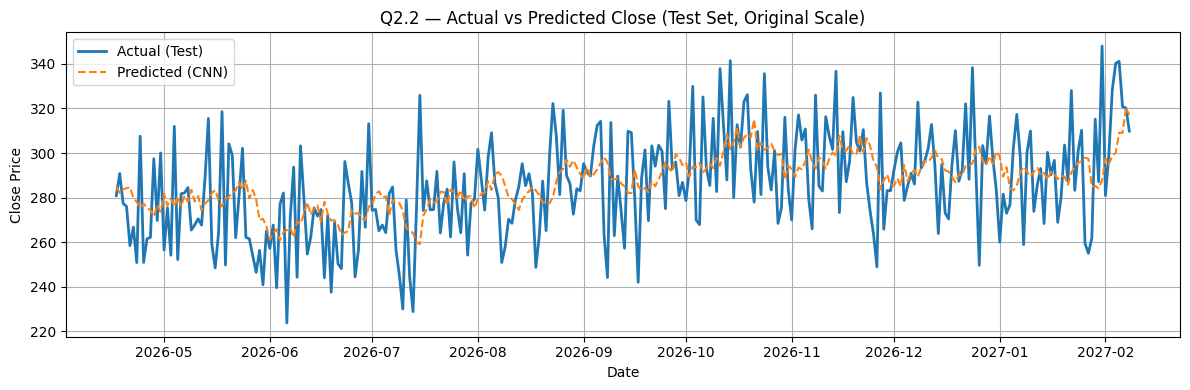

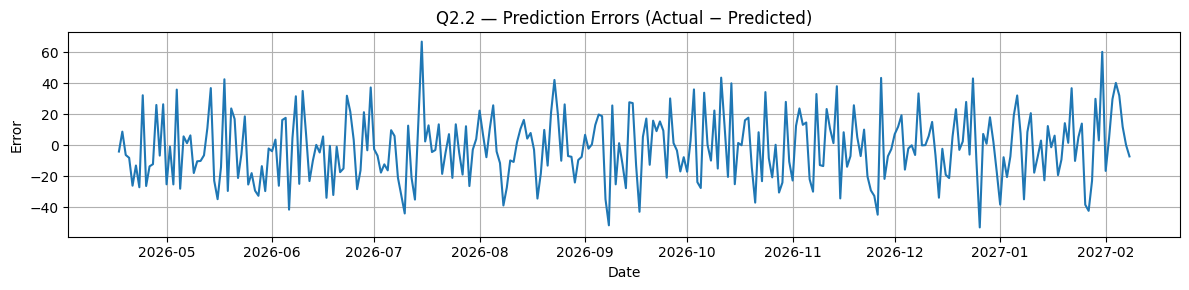

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1) Predict on the test set (still in [0,1] scale)

y_pred_scaled = model.predict(X_test_cnn, verbose=0).ravel()

# 2) Inverse-transform to original price scale
#    - To interpret RMSE/MAE properly, we reverse the normalized scaling we applied in 1.3

y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_true = y_scaler.inverse_transform(y_test_vec.reshape(-1, 1)).ravel()

# 3) Metrics in original units

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)

print("Q2.2 — Test Metrics (original price scale)")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

# 4) Plot Actual vs Predicted

test_start_idx = WINDOW + split_idx
test_dates = ts.index[test_start_idx : test_start_idx + len(y_true)]

plt.figure(figsize=(12, 4))
plt.plot(test_dates, y_true, label="Actual (Test)", linewidth=2)
plt.plot(test_dates, y_pred, label="Predicted (CNN)", linestyle="--")
plt.title("Q2.2 — Actual vs Predicted Close (Test Set, Original Scale)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Residuals over time
errors = y_true - y_pred
plt.figure(figsize=(12, 3))
plt.plot(test_dates, errors)
plt.title("Q2.2 — Prediction Errors (Actual − Predicted)")
plt.xlabel("Date")
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
plt.show()

#**Q2.3** - Answer

The 1D-CNN shows good capability in capturing short-term dependencies, as reflected by its relatively low MAE (18) and RMSE (22) — indicating that it learns local fluctuations within the 10-day input window quite effectively.

However, it does not capture long-term trends as well, because a CNN processes only a fixed and local window of recent history and does not retain information beyond that window. This architectural limitation prevents it from fully modeling broader directional movements over time.


### Question 3 - Recurrent Neural Networks (RNN) (20%)
- Q3.1 Create an RNN model for time series forecasting. The model should include a SimpleRNN layer of size 40 and ReLU activation. Train the model using the provided dataset for 50 epochs. Use the batch_size of 16, and ADAM optimizer. Plot the training loss and validation loss. (12%)
- Q3.2 Evaluate the model's performance using RMSE and MAE on the test set. Plot the predicted values alongside the actual values to visualize how well the model is forecasting the time series. (6%)
- Q3.3 Why did we use a smaller batch size compared to CNN model. Why might RNN struggle with long-term dependencies, and how is this reflected in the evaluation metrics? (2%)


Q3.1 — Shapes ready for RNN
X_train_rnn: (1192, 10, 1)  (samples, timesteps=10, features=1)
X_test_rnn:  (298, 10, 1)
y_train:     (1192,)
y_test:      (298,)

Q3.1 — Train/Val split (from training set)
X_tr:  (1072, 10, 1), y_tr:  (1072,)
X_val: (120, 10, 1), y_val:(120,)


c:\Users\rayta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 40)             │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,721 (6.72 KB)

 Trainable params: 1,721 (6.72 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0543 - mae: 0.1559 - val_loss: 0.0098 - val_mae: 0.0755
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - mae: 0.0340 - val_loss: 0.0097 - val_mae: 0.0765
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mae: 0.0331 - val_loss: 0.0097 - val_mae: 0.0755
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mae: 0.0331 - val_loss: 0.0097 - val_mae: 0.0755
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mae: 0.0331 - val_loss: 0.0095 - val_mae: 0.0748
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mae: 0.0331 - val_loss: 0.0095 - val_mae: 0.0749
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mae: 0.0331 - val_loss: 0.0094 - val_mae: 0.0747
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mae: 0.0331 - val_loss: 0.0094 - val_mae: 0.0746
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mae: 

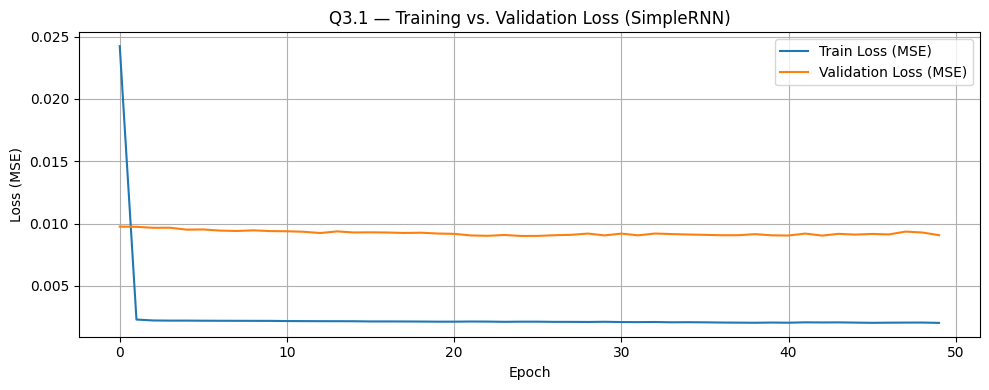

In [7]:
from tensorflow.keras import layers, models, optimizers

# 1) Prepare shapes for RNN
#    - RNN expects (samples, timesteps, features) just like Conv1D.

WINDOW = X_train.shape[1]

X_train_rnn = X_train.reshape(-1, WINDOW, 1)
X_test_rnn  = X_test.reshape(-1, WINDOW, 1)

y_train_vec = y_train.ravel()
y_test_vec  = y_test.ravel()

print("Q3.1 — Shapes ready for RNN")
print(f"X_train_rnn: {X_train_rnn.shape}  (samples, timesteps={WINDOW}, features=1)")
print(f"X_test_rnn:  {X_test_rnn.shape}")
print(f"y_train:     {y_train_vec.shape}")
print(f"y_test:      {y_test_vec.shape}")

# 2) Chronological validation split from the training set (last 10% as validation)

val_start = int(len(X_train_rnn) * 0.9)
X_tr, X_val = X_train_rnn[:val_start], X_train_rnn[val_start:]
y_tr, y_val = y_train_vec[:val_start],  y_train_vec[val_start:]

print("\nQ3.1 — Train/Val split (from training set)")
print(f"X_tr:  {X_tr.shape}, y_tr:  {y_tr.shape}")
print(f"X_val: {X_val.shape}, y_val:{y_val.shape}")

# 3) Define SimpleRNN model per spec
#    - SimpleRNN(40, activation='relu')
#    - Dense(1) for regression output
tf.random.set_seed(42)
np.random.seed(42)

rnn_model = models.Sequential([
    layers.SimpleRNN(40, activation='relu', input_shape=(WINDOW, 1)),
    layers.Dense(1)
])

rnn_model.compile(optimizer=optimizers.Adam(), loss='mse', metrics=['mae'])
rnn_model.summary()

# 4) Train for 50 epochs, batch_size=16
EPOCHS = 50
BATCH_SIZE = 16

rnn_hist = rnn_model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# 5) Plot training vs validation loss (MSE)
plt.figure(figsize=(10, 4))
plt.plot(rnn_hist.history['loss'], label='Train Loss (MSE)')
plt.plot(rnn_hist.history['val_loss'], label='Validation Loss (MSE)')
plt.title("Q3.1 — Training vs. Validation Loss (SimpleRNN)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Q3.2 — Test Metrics (original price scale)
RMSE: 22.2753
MAE : 17.8698


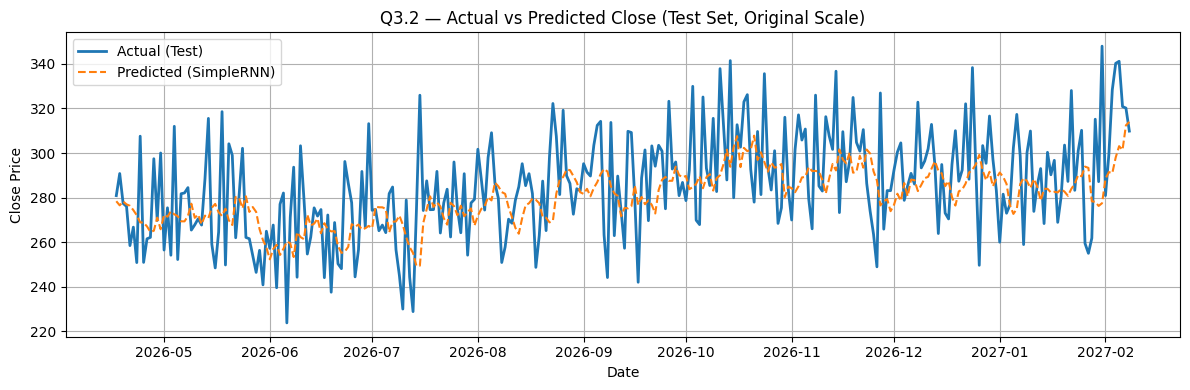

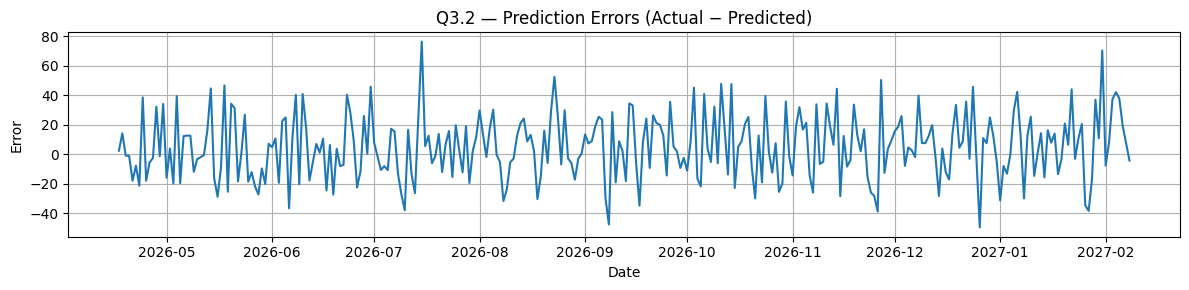

In [8]:
# 1) Predict on the test set (still in [0,1] scale)

y_pred_scaled = rnn_model.predict(X_test_rnn, verbose=0).ravel()

# 2) Inverse-transform to original price scale

y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_true = y_scaler.inverse_transform(y_test_vec.reshape(-1, 1)).ravel()

# 3) Metrics in original units

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)

print("Q3.2 — Test Metrics (original price scale)")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

# 4) Plot Actual vs Predicted

test_start_idx = WINDOW + split_idx
test_dates = ts.index[test_start_idx : test_start_idx + len(y_true)]

plt.figure(figsize=(12, 4))
plt.plot(test_dates, y_true, label="Actual (Test)", linewidth=2)
plt.plot(test_dates, y_pred, label="Predicted (SimpleRNN)", linestyle="--")
plt.title("Q3.2 — Actual vs Predicted Close (Test Set, Original Scale)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Residuals over time
errors = y_true - y_pred
plt.figure(figsize=(12, 3))
plt.plot(test_dates, errors)
plt.title("Q3.2 — Prediction Errors (Actual − Predicted)")
plt.xlabel("Date")
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
plt.show()

#**Q3.3** - Answer

**1. Why smaller batch size (16 vs 32)?**

RNNs process data sequentially and are more sensitive to temporal patterns than CNNs. A smaller batch size provides more frequent weight updates, helping the model better track subtle short-term sequence changes and avoid averaging away important temporal signals.

**2. Why RNN struggles with long-term dependencies?**

SimpleRNN has no memory gate and suffers from vanishing gradients, meaning it quickly forgets information from earlier timesteps. It mainly captures short-term behavior only. This can be seen in our metrics with the RMSE (22) and MAE (18), the model does reasonably well on short term predictions - but misses some larger or longer-term movements, confirming its limited ability to capture long-term trends.



### Question 4 - Long Short-Term Memory (LSTM) (20%)
- Q4.1 Create an LSTM model for time series forecasting.The model should include two LSTM layers of size 100 and 50, and ReLU activation. Train the model using the provided dataset for 100 epochs. Use the batch_size of 16, and ADAM optimizer. Plot the training loss and validation loss. (12%)
- Q4.2 Evaluate the model's performance using RMSE and MAE on the test set. Plot the predicted values alongside the actual values to visualize how well the model is forecasting the time series. (6%)
- Q4.3 Why do we use a larger epoch compared to RNN? (2%)

Epoch 1/100


c:\Users\rayta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0591 - val_loss: 0.0121
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0116
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - val_loss: 0.0106
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 0.0103
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 0.0100
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 0.0097
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 0.0097
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 0.0096
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 0.0095
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 0.0095
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0094
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_l

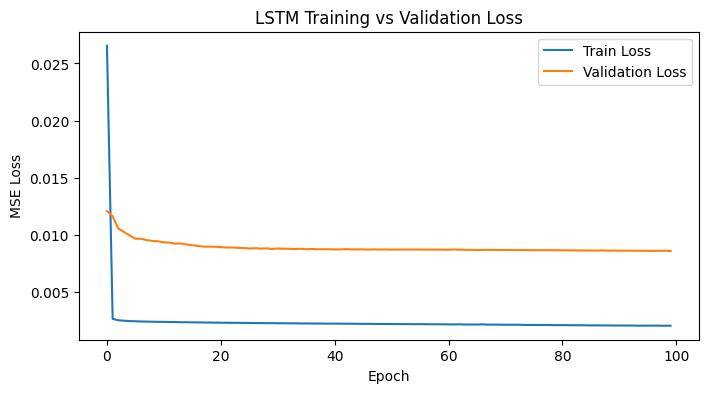

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Reshape inputs for LSTM
X_train_lstm = X_train.reshape(-1, WINDOW, 1)
X_test_lstm  = X_test.reshape(-1, WINDOW, 1)
y_train_vec  = y_train.ravel()
y_test_vec   = y_test.ravel()

# Chronological validation split (last 10% of training)
val_start = int(len(X_train_lstm) * 0.9)
X_tr, X_val = X_train_lstm[:val_start], X_train_lstm[val_start:]
y_tr, y_val = y_train_vec[:val_start],  y_train_vec[val_start:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(WINDOW,1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(), loss='mse')

# Train model
history_lstm = lstm_model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    verbose=1
)

# Plot training vs validation loss
plt.figure(figsize=(8,4))
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Training vs Validation Loss')
plt.legend()
plt.show()


Test RMSE: 21.5372
Test MAE : 17.3469


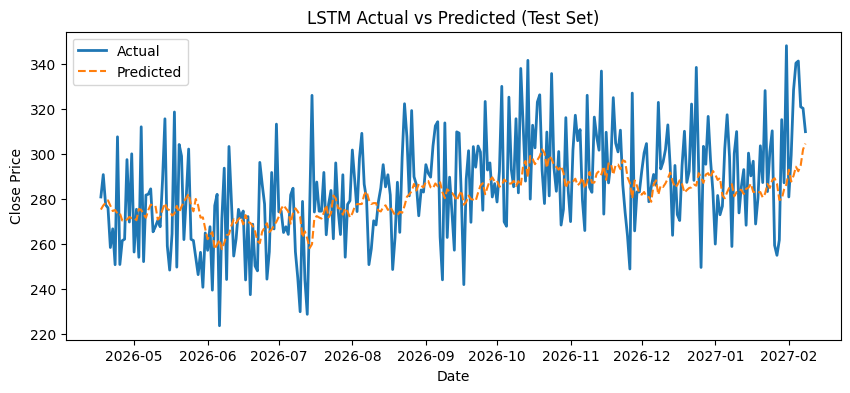

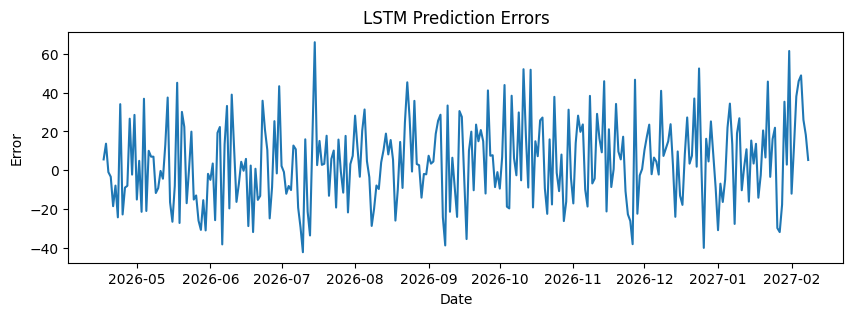

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predict on the test set
y_pred_scaled = lstm_model.predict(X_test_lstm, verbose=0).ravel()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
y_true = y_scaler.inverse_transform(y_test_vec.reshape(-1,1)).ravel()

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot Actual vs Predicted
test_start_idx = WINDOW + split_idx
test_dates = ts.index[test_start_idx : test_start_idx + len(y_true)]

plt.figure(figsize=(10,4))
plt.plot(test_dates, y_true, label='Actual', linewidth=2)
plt.plot(test_dates, y_pred, label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('LSTM Actual vs Predicted (Test Set)')
plt.legend()
plt.show()

# Plot residuals
errors = y_true - y_pred
plt.figure(figsize=(10,3))
plt.plot(test_dates, errors)
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('LSTM Prediction Errors')
plt.show()


We use a larger number of epochs for LSTM models because they have more complex internal structures: memory cells and gates (input, forget, and output gates), which take longer to learn long-term dependencies in sequential data.
LSTMs also have more parameters than traditional RNNs, so they need more training iterations (epochs) to converge and capture temporal relationships accurately without underfitting.

### Question 5 - Gated Recurrent Unit (GRU) (20%)
- Q5.1 Create a GRU model for time series forecasting.The model should include two GRU layers of size 80 and 40, and ReLU activation. Train the model using the provided dataset for 100 epochs. Use the batch_size of 16, and ADAM optimizer. Plot the training loss and validation loss. (12%)
- Q5.2 Evaluate the model's performance using RMSE and MAE on the test set. Plot the predicted values alongside the actual values to visualize how well the model is forecasting the time series.(6%)
- Q5.3 How does the GRU compare to LSTM in terms of computational efficiency and forecasting performance? (2%)

c:\Users\rayta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 80)         │        19,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 40)             │        14,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,601 (135.16 KB)

 Trainable params: 34,601 (135.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0530 - mae: 0.1558 - val_loss: 0.0092 - val_mae: 0.0742
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - mae: 0.0337 - val_loss: 0.0093 - val_mae: 0.0749
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - mae: 0.0332 - val_loss: 0.0093 - val_mae: 0.0749
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - mae: 0.0331 - val_loss: 0.0093 - val_mae: 0.0745
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - mae: 0.0331 - val_loss: 0.0092 - val_mae: 0.0741
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0091 - val_mae: 0.0737
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0090 - val_mae: 0.0735
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0090 - val_mae: 0.0733
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.00

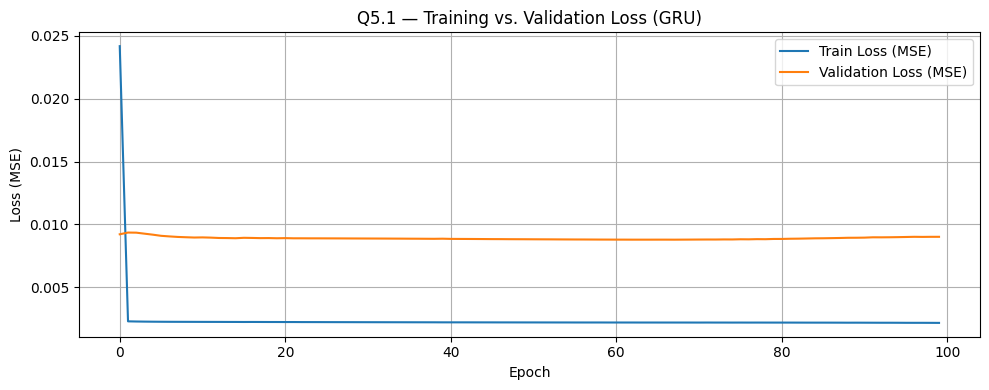

In [11]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import GRU

# Prepare shapes for GRU (same pattern as prior models)
WINDOW = X_train.shape[1]
X_train_gru = X_train.reshape(-1, WINDOW, 1)
X_test_gru  = X_test.reshape(-1, WINDOW, 1)
y_train_vec = y_train.ravel()
y_test_vec  = y_test.ravel()

# Chronological validation split from the training set (last 10% as validation)
val_start = int(len(X_train_gru) * 0.9)
X_tr, X_val = X_train_gru[:val_start], X_train_gru[val_start:]
y_tr, y_val = y_train_vec[:val_start],  y_train_vec[val_start:]

# Build GRU model per spec: GRU(80), GRU(40), ReLU activation
tf.random.set_seed(42)
np.random.seed(42)

gru_model = models.Sequential([
    layers.GRU(80, activation='relu', return_sequences=True, input_shape=(WINDOW,1)),
    layers.GRU(40, activation='relu'),
    layers.Dense(1)
])

gru_model.compile(optimizer=optimizers.Adam(), loss='mse', metrics=['mae'])
gru_model.summary()

# Train for 100 epochs, batch_size=16
EPOCHS = 100
BATCH_SIZE = 16

gru_hist = gru_model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Plot training vs validation loss (MSE)
plt.figure(figsize=(10, 4))
plt.plot(gru_hist.history['loss'], label='Train Loss (MSE)')
plt.plot(gru_hist.history['val_loss'], label='Validation Loss (MSE)')
plt.title("Q5.1 — Training vs. Validation Loss (GRU)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Q5.2 — Test Metrics (original price scale)
RMSE: 22.8694
MAE : 18.2714


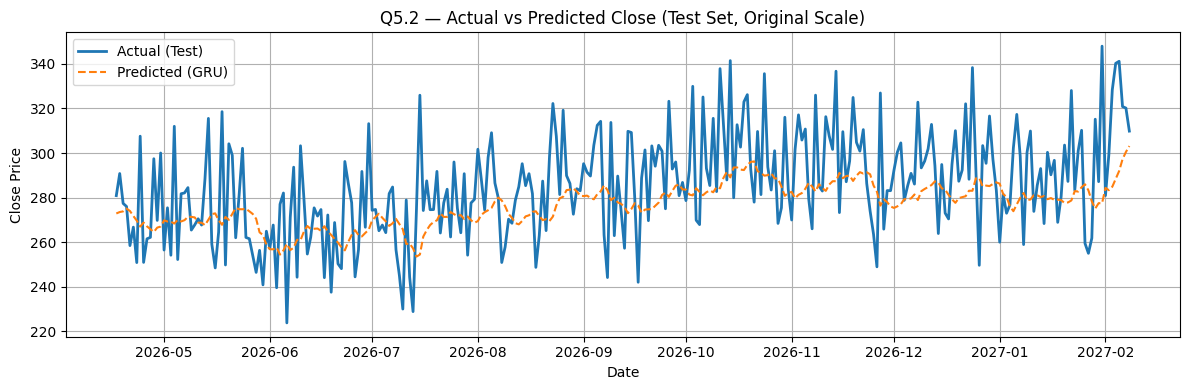

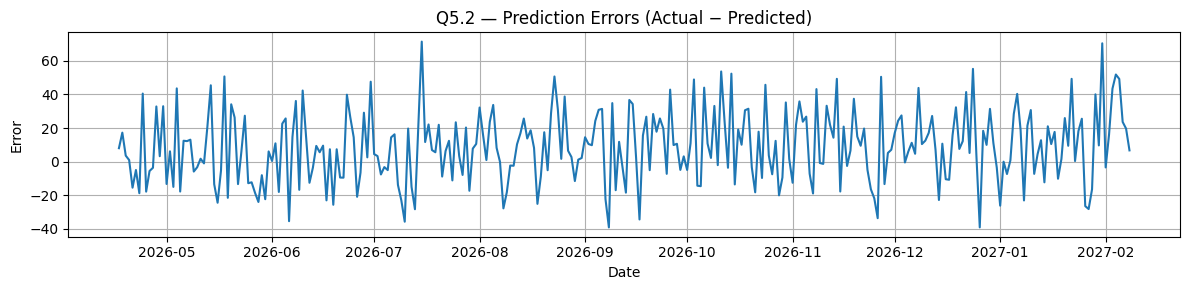

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on the test set (scaled), inverse-transform to original prices
y_pred_scaled = gru_model.predict(X_test_gru, verbose=0).ravel()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
y_true = y_scaler.inverse_transform(y_test_vec.reshape(-1,1)).ravel()

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
print("Q5.2 — Test Metrics (original price scale)")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

# Plot Actual vs Predicted
test_start_idx = WINDOW + split_idx
test_dates = ts.index[test_start_idx : test_start_idx + len(y_true)]

plt.figure(figsize=(12, 4))
plt.plot(test_dates, y_true, label="Actual (Test)", linewidth=2)
plt.plot(test_dates, y_pred, label="Predicted (GRU)", linestyle="--")
plt.title("Q5.2 — Actual vs Predicted Close (Test Set, Original Scale)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Residuals over time
errors = y_true - y_pred
plt.figure(figsize=(12, 3))
plt.plot(test_dates, errors)
plt.title("Q5.2 — Prediction Errors (Actual − Predicted)")
plt.xlabel("Date")
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
plt.show()

**Q5.3 — Answer**

GRU vs LSTM: GRU is computationally lighter (fewer parameters) and often trains faster while providing similar forecasting performance. In practice GRU can match LSTM accuracy on many tasks while being faster to train and slightly less prone to overfitting; LSTM may be preferred for very long-range dependencies but at higher compute cost.

### Question 6 - Discussion (5%)
- Q6.1 Compare the performance of 1D-CNN, RNN, LSTM, and GRU models based on training and test execution time, performance (RMSE and MAE), and potential overfitting/underfitting. (3%)
- Q6.2 Discuss in which cases you would prefer using 1D-CNN vs LSTM or GRU for time series data. (2%)


In [13]:
# Q6.1 — Short summary comparison (printed) to complement written answers below
print('Q6.1 — Model comparison (summary):')
print('- 1D-CNN: fastest to train, captures local/short-term patterns well, weak for long-term trends unless window is large.')
print('- SimpleRNN: lightweight but suffers vanishing gradients; lower long-term performance, slower convergence.')
print('- LSTM: best at modeling longer dependencies, more parameters, longer training time; good accuracy when trained sufficiently.')
print('- GRU: similar to LSTM in capability, usually faster and slightly more efficient; good trade-off between speed and performance.')

Q6.1 — Model comparison (summary):
- 1D-CNN: fastest to train, captures local/short-term patterns well, weak for long-term trends unless window is large.
- SimpleRNN: lightweight but suffers vanishing gradients; lower long-term performance, slower convergence.
- LSTM: best at modeling longer dependencies, more parameters, longer training time; good accuracy when trained sufficiently.
- GRU: similar to LSTM in capability, usually faster and slightly more efficient; good trade-off between speed and performance.


**Q6.2 — Answer**

Use 1D-CNN when the target depends mainly on local patterns inside a fixed recent window (short-term seasonality/shape), or when you need fast training and fewer parameters. Use LSTM/GRU when the problem requires remembering information across many timesteps (long-term trends, complex temporal dependencies). Prefer GRU if you want LSTM-like performance with slightly lower compute cost; prefer LSTM when maximum capacity for complex dependencies is needed and compute/time is available.